In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
dtype = {
    'rate-reason-deletions': 'Int64',
    'rate-RAT-introductions': 'Int64',
    'rate-RUP-introductions': 'Int64',
}
checkers = 'rate', 'rate-d', 'drat-trim', 'gratgen'
df = pd.read_csv('results.csv', dtype=dtype)

df['time-delta-rate-rate-d'] = df['rate-time'] - df['rate-d-time']
df['time-delta-percent-rate-rate-d'] = (df['rate-time'] - df['rate-d-time']) / df['rate-time']
df['time-delta-percent-d-rate-rate-d'] = (df['rate-time'] - df['rate-d-time']) / df['rate-d-time']
df['space-delta-rate-rate-d'] = df['rate-space'] - df['rate-d-space']

vf = df[ (df['rate-result'] == 'verified')
         & (df['rate-d-result'] == 'verified')
         & (df['drat-trim-result'] == 'verified')
         & (df['gratgen-result'] == 'verified')
]
rvf = df[ (df['rate-result'] == 'verified') & (df['rate-d-result'] == 'verified') ]


In [4]:
def sort_by_col(df, col):
    tmp = df.sort_values(col)
    tmp['index'] = np.arange(len(tmp))
    return tmp

def compare(df, what, **kwargs):
    ax = plt.subplot()
    x = list(range(len(df)))
    for checker in checkers:
        ax = sort_by_col(df, f'{checker}-{what}').plot(x='index', y=f'{checker}-{what}', ax=ax, **kwargs)
        plt.xlabel('verified proofs')
        plt.ylabel(what)

def crossplot(df, x, y):
    limit = max(df[x].max(), df[y].max()) * 1.02
    ax = df.plot(x, y, kind='scatter', marker='1', xlim=(0, limit), ylim=(0, limit))
    ax.plot((0, limit), (0, limit), color='green', linestyle='dashed', linewidth=1)

def correlation(df, x, y, **kwargs):
    ax = plt.subplot()
    rvf.plot(x, y, ax=ax, kind='scatter', marker='3', **kwargs);
    limit = df[x].max()
    ax.plot((0, limit), (0, 0), color='green', linestyle='dashed', linewidth=1)

SAVE_FIGURES = 1
def persist(name, needPNG=False):
    if SAVE_FIGURES:
        plt.savefig(f'p/{name}.svg')
        if needPNG:
            plt.savefig(f'p/{name}.png')

In [5]:
vf[[f'{checker}-time' for checker in checkers]].describe()

,rate-time,rate-d-time,drat-trim-time,gratgen-time
count,298.000000,298.000000,298.000000,298.000000
mean,1291.571644,1261.949396,1463.082248,1009.904329
std,2121.281030,2152.958351,2572.730258,1845.386325
min,0.290000,0.290000,0.580000,0.310000
25%,53.412500,47.787500,70.425000,44.260000
50%,513.015000,505.235000,624.830000,391.560000
75%,1311.145000,1199.340000,1377.980000,959.085000
max,13971.950000,16061.130000,15554.620000,11609.950000


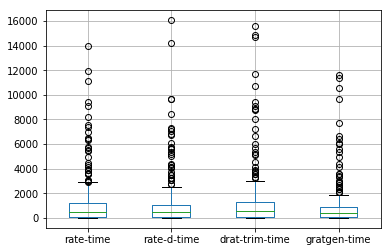

In [234]:
rupf = vf[vf['rate-RAT-introductions'] == 0]
rupf[[f'{checker}-time' for checker in checkers]].boxplot(); persist('box-time')

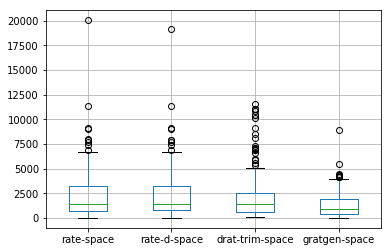

In [235]:
vf[[f'{checker}-space' for checker in checkers]].boxplot(); persist('box-space')

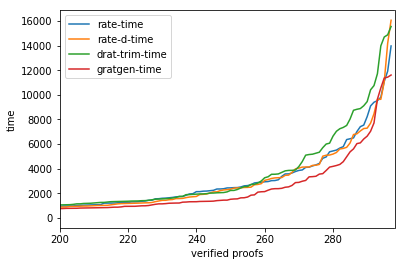

In [236]:
compare(vf, 'time', xlim=(200, len(vf))); persist('cactus-time', needPNG=1)

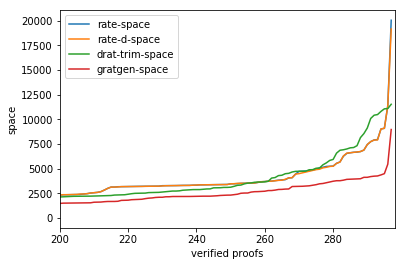

In [237]:
compare(vf, 'space', xlim=(200, len(vf))); persist('cactus-space')

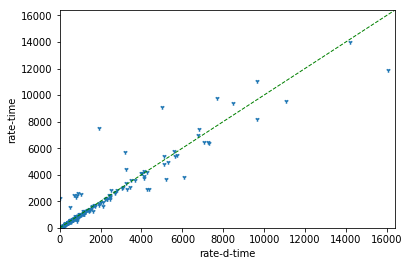

In [238]:
crossplot(vf, 'rate-d-time', 'rate-time'); persist('cross-rate-d-rate')

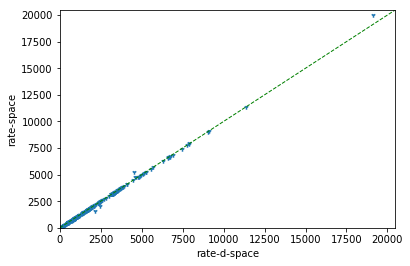

In [239]:
crossplot(vf, 'rate-d-space', 'rate-space');

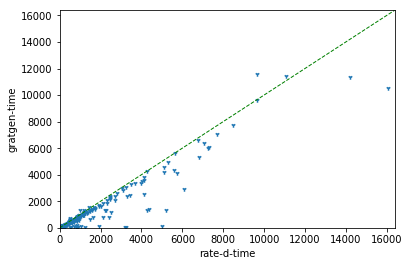

In [240]:
crossplot(vf, 'rate-d-time', 'gratgen-time'); persist('cross-rate-d-gratgen')

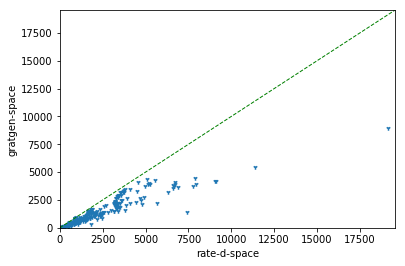

In [241]:
crossplot(vf, 'rate-d-space', 'gratgen-space');

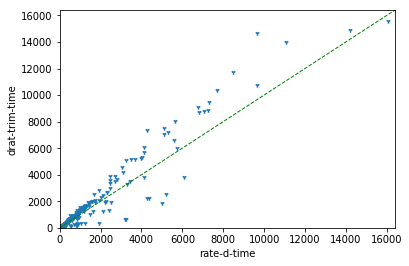

In [242]:
crossplot(vf, 'rate-d-time', 'drat-trim-time'); persist('cross-rate-d-drat-trim')

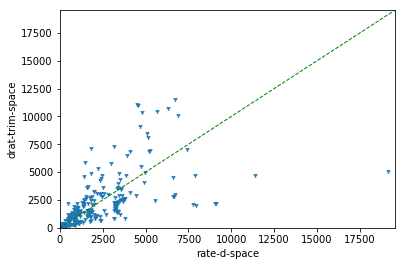

In [243]:
crossplot(vf, 'rate-d-space', 'drat-trim-space');

# Correlation

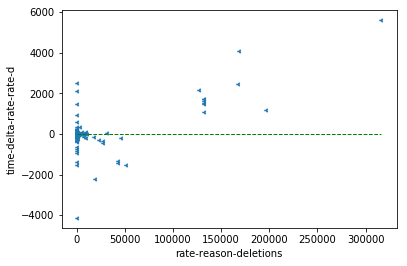

In [266]:
correlation(rvf, 'rate-reason-deletions', 'time-delta-rate-rate-d'); persist('correlation-reason-deletions-time-delta'); persist('correlation-reason-deletions-time-delta', needPNG=1)

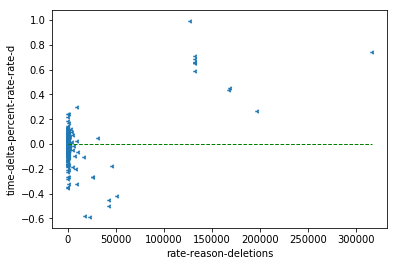

In [265]:
correlation(rvf, 'rate-reason-deletions', 'time-delta-percent-rate-rate-d');

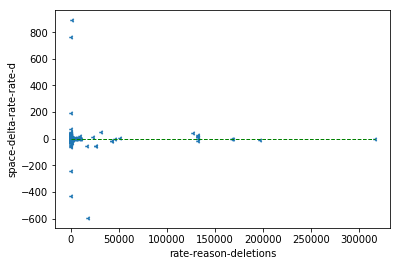

In [267]:
correlation(rvf, 'rate-reason-deletions', 'space-delta-rate-rate-d'); persist('correlation-reason-deletions-space-delta')